## Inference over a planar robotic arm - edit
This model implements a state-space model for rigid body dynamics of the robotic arm.

Our state-space $\mathbf{x} \in \mathbb{R}^6 $ includes torques $\tau_i$, angles $\theta_i$ and angular velocities $\dot{\theta}_i$. We append all static parameters in $\phi = \{L_{1}, L_{2}, M_{1}, M_{2}\}$.

$$
\mathbf{x} = \begin{pmatrix} \mathbf{x}_1 = \tau_1 \\  \mathbf{x}_2 = \tau_2 \\ \mathbf{x}_3 =\theta_1 \\ \mathbf{x}_4 =\theta_2 \\
\mathbf{x}_5 = \dot{\theta}_1 \\ \mathbf{x}_6 = \dot{\theta}_2 \end{pmatrix}, \quad \mathbf{\dot{x}} = \begin{pmatrix} 0 \\  0 \\ \mathbf{x}_5 \\ \mathbf{x}_6 \\ \mathbf{D}^{-1}(\mathbf{x}_4, \phi) [\begin{pmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{pmatrix} - \mathbf{c}(\mathbf{x}_3, \mathbf{x}_4) -\mathbf{h}(\mathbf{x}_4, \mathbf{x}_5, \mathbf{x}_6) ]
\end{pmatrix}  := a(\mathbf{x})
$$

Where $\mathbf{D} \in \mathbb{R}^{2 \times 2}$ is the inertia tensor and $\mathbf{c},\mathbf{h} \in \mathbb{R}^{2}$ are gravity and fictitious forces vectors, respectively.

Note that $a(\mathbf{x})$ is non-linear because (1) the operation $\mathbf{D}^{-1}(\mathbf{x}_4, \phi) \begin{pmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{pmatrix}$, and (2) $\mathbf{c},\mathbf{h}$ are non-linear functions of the state.

with noise on the torque

$$
\mathbf{\dot{x}} = a(\mathbf{x}) + \begin{pmatrix} 1 \\ 1 \\ 0 \\ 0\\0\\0\end{pmatrix} \nu, \quad \nu \sim \mathcal{N}(0,1)
$$

with Euler discretizetion 

$$
\mathbf{x}_{t+\Delta{t}} = \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \Delta{t} \\ 0 \\ 0 \\ 0 \\0 \end{pmatrix} \nu_t \approx \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \Delta{t} \\ \sigma \\ \sigma \\ \sigma \\\sigma \end{pmatrix} \nu_t
 $$

where we introduce $\sigma<<\Delta{t}$ to avoid a degenerate distribution.
So our transition is defined as follows:

$$
f(\mathbf{x}_{t+\Delta{t}}|\mathbf{x}_t) = \mathcal{N}(\mathbf{x}_t + \Delta{t}a(\mathbf{x}_t), \text{diag}(\Delta{t}^2,\Delta{t}^2, \sigma, \sigma, \sigma, \sigma))
$$

The emission is 

$$
g(\mathbf{y}_t | \mathbf{x}_t) = \text{FW-KIN}(\mathbf{x}_3, \mathbf{x}_4)
$$

## Concepts Explored in this notebook
The full model from torques to coordinates $\mathbf{\tau} \rightarrow \mathbf{y}$ can be estimated properly with enough independent SMC samplers. In this implementation, the batch dimension of each tensor is used as an independent SMC sampler.

For parameter learning $\theta : = \{M_1, M_2, L_1, L_2\}$, we do not need to use SMC samplers; `batch_size` could be small, even 1. in each SGD iteration, I estimate the states $\mathbf{x}$. Some SGD iterations will be good and some bad, but we assume that they're good enough. Then, offline, we use many independent particle filters.

In [1]:
import os
import inspect
print(os.getcwd())
plot_folder = '3d_arm_dyn_plots'

/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test


In [2]:
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)

In [3]:
parent_dir

'/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc'

In [4]:
# change dir to import from aesmc
os.chdir(parent_dir)
import aesmc.statistics as statistics
import aesmc.inference as inference
import aesmc.train as train
import aesmc.losses as losses
import aesmc.state as state
import aesmc.math as math
import aesmc.smoothing as smoothing

In [5]:
# change dir to import from aesmc/test
os.chdir(current_dir)
from arm_models import arm_3d_dyn_model # the model script -- distribution objects are defined there
from arm_models import arm_utils # make video, plot post, params to coords
from arm_models import utils_summary
from arm_models import proposal_objects

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [7]:
# matplotlib general settings 
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

mpl.rcParams['lines.linewidth'] = 4.0

In [8]:
# def sim_data_from_model(model_dict, num_timesteps, batch_size, repeat_data):
#     '''this utility just allows to pass a model_dict with
#     "initial", "transition", and "emission" objects.'''
#     sim_lats, sim_observs = statistics.sample_from_prior(
#         model_dict["initial"], model_dict["transition"],
#         model_dict["emission"], num_timesteps, batch_size, repeat_data)
#     return sim_lats, sim_observs

In [9]:
# def infer_latents(model_dict, observations, num_particles):
#     """wrapper around aesmc.inference.infer that allows to input a model_dict
#     with the four distribution objects. note, currently 
#     Args: 
#         model_dict: [dict] with initial, transition, emission, and proposal
#         observations: [list] of length num_timepoints with each entry a tensor
#         torch.Size(batch_size, dim_obs)
#         num_particles: [int]
#     Returns:
#         list with latents, log_weights, etc."""
#     import time as time
#     start_time_fw = time.time()
#     inference_result = inference.infer(
#         inference_algorithm='smc',
#         observations=observations,
#         initial=model_dict["initial"],
#         transition=model_dict["transition"],
#         emission=model_dict["emission"],
#         proposal=model_dict["proposal"],
#         num_particles=num_particles,
#         return_log_weights=True,
#         return_log_marginal_likelihood=True,
#     )
#     print('run time for %i timesteps, %i batches, %i particles = %.2f' % \
#       (len(observations), observations[-1].shape[0],
#        num_particles, time.time() - start_time_fw))
#     return inference_result

In [10]:
# def plot_simulated_data(lat_data_np, 
#                         sim_data_np, 
#                         ind_in_batch,
#                         label_dict,
#                        fig_full_path):
#     plt.subplot(121)
#     plt.plot(lat_data_np[ind_in_batch, :, :].T)
#     plt.title('simulated states')
#     plt.ylabel('variable values')
#     plt.xlabel('time / dt')
#     plt.legend(label_dict["state"])
#     plt.subplot(122)
#     plt.plot(sim_data_np[ind_in_batch, :, :].T)
#     plt.title('simulated observations')
#     plt.ylabel('variable values')
#     plt.xlabel('time / dt')
#     plt.legend(label_dict["obs"])
#     plt.tight_layout()
#     plt.savefig(fig_full_path)

In [11]:
# define global model params
dt = 0.01 # time interval between observations
g = 1.0 # gravity 
dim_latents = 12 # always 6 in the full planar arm model.
transition_force_scale = 2.0 # 2.0 was best for 3d; 20.0 was best for 2d; tried also 10, 30, 50. tried 1.0 for hand-engineered
transition_aux_scale = ((dt**2)*transition_force_scale**2) / (10.0) #* 2
initial_loc = 0.0 # natural choice.
initial_scale = 0.001 #0.001 didn't blow up (but it can't infer), everything above did. #0.5 worked for planar # in future could be different per dimension.
emission_var_diag = 0.01 # was 0.1 before. this varies with the application. 
print('torque effective variance: %.5f' %((dt**2)*transition_force_scale**2))
print('auxilliary variance: %.5f' % transition_aux_scale)

torque effective variance: 0.00040
auxilliary variance: 0.00004


In [12]:
#TODO- modify the inits.

In [13]:
# put params into dicts
param_dict = {}
param_dict["init_mu"] = initial_loc * np.ones(dim_latents) #TODO: modify
param_dict["init_cov"] = np.eye(dim_latents) * initial_scale #TODO: correct this, this isn't scale, it's variance.

inits_dict = {}
inits_dict["L1"] = 1.0
inits_dict["L2"] = 1.0
inits_dict["M1"] = 0.5 #1.1
inits_dict["M2"] = 0.3 #1.2

In [14]:
os.getcwd()

'/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test'

In [15]:
fit_to_hand_engineered_dataset = False
if fit_to_hand_engineered_dataset:
    #sim_data_obj = load_object('arm_models/sim_dataset_3d_planar_special_case')
    sim_data_obj = load_object('arm_models/sim_dataset_3d')
    # inits are true params (first pass; later test learning)
    inits_dict["L1"] = sim_data_obj["params"]["L1"]
    inits_dict["L2"] = sim_data_obj["params"]["L2"]
    inits_dict["M1"] = sim_data_obj["params"]["M1"]
    inits_dict["M2"] = sim_data_obj["params"]["M2"]
    g = sim_data_obj["params"]["g"]
    dt = sim_data_obj["params"]["delta_t"]

In [16]:
# running params
num_timesteps = 200
if fit_to_hand_engineered_dataset:
    num_timesteps = sim_data_obj["sim_states"].shape[1]
saving_interval = 10
logging_interval = 10
batch_size = 64 # 64 is good for independent SMC. the higher the better.
num_iterations = 500
num_particles = 1000

In [17]:
# initialize arm model, used by transition and proposal.
arm_model_instance = arm_3d_dyn_model.Arm_3D_Dyn(
    dt=dt,
    inits_dict=inits_dict,
    g=g,
    include_gravity_fictitious=True,
    transform_torques=False,
    learn_static=False,
    restrict_to_plane=False, # Remove in full model!
    clamp_state_value= None,
    constrain_phase_space=False,
    angle_constraint = False,
    velocity_constraint= False,
    constrain_angles_hard=True,
    torque_dyn= 'Langevin') 
# RUN below ONLY if want to change and test. can remove.
arm_model_instance.alpha_constraint = 5.0 # n
arm_model_instance.min_angles = np.ones(4)* (-np.pi)
arm_model_instance.max_angles = np.ones(4)* (+np.pi)
print(arm_model_instance.Langevin_lambda)

2.0


In [18]:
list(arm_model_instance.parameters())

[Parameter containing:
 tensor(1.),
 Parameter containing:
 tensor(1.),
 Parameter containing:
 tensor(0.5000),
 Parameter containing:
 tensor(0.3000)]

In [19]:
full_model = {}
'''full_model includes arm dynamics, and FW-KIN emission.
we use it to simulate ground truth data, and inference. 
with realistic data, params will have to be learned.'''

full_model["initial"] = arm_3d_dyn_model.Initial(param_dict["init_mu"],
                                                     param_dict["init_cov"])

full_model["transition"] = arm_3d_dyn_model.Transition(
    dt, transition_force_scale, transition_aux_scale, arm_model_instance)

full_model["emission"] = arm_3d_dyn_model.Emission(inits_dict, #ToDo: inits_dict is now redundant for L1,L2
                                                       np.eye(9) *
                                                       emission_var_diag,
                                                       arm_model_instance,
                                                       theta_indices=[4,5,6,7])

In [20]:
## Commented out just for debugging
full_model["proposal"] = proposal_objects.Bootstrap_Proposal( \
                               full_model["initial"], full_model["transition"])
# full_model["proposal"] = proposal_objects.Learned_Proposal( \
#                                full_model["initial"], 
#                                 full_model["transition"],
#                                 20)

In [21]:
# list(full_model["proposal"].parameters())

### choose proposal -- options:
#### Bootstrap proposal:
`proposal = planar_arm_dyn_model.Bootstrap_Proposal_Short( \
                                initial, transition)`
#### Optimal proposal:
`proposal = planar_arm_dyn_model.Optimal_Proposal(initial, transition, emission)`

## Simulate from full model and infer states
Can we infer the true dynamics?

In [22]:
np.random.seed(0)
torch.manual_seed(0)

In [23]:
# # no need for now, this is a stable dyn. to simulate from.
# full_model["transition"].arm_model.A = 1.0* torch.tensor([[-1,1],[-1,-1]], dtype = torch.double)
# full_model["transition"].arm_model.A

In [24]:
# simulate from full model.
sim_lats, sim_observs = statistics.sim_data_from_model(full_model, 
                                            num_timesteps,
                                            batch_size, True)
# if simulating from a deterministic model
print(np.sum(np.isnan(torch.cat(sim_observs).cpu().numpy())))
print(np.sum(np.isnan(torch.cat(sim_lats).cpu().numpy())))

repeating data in batch.
0
0


In [25]:
def debug_forward_simulator(full_model, num_timesteps, batch_size,
                           repeat_data_in_batch, num_runs):
    '''forward simulate multiple times and print nan count, min and max values'''
    for i in range(num_runs):
        sim_lats, sim_observs = statistics.sim_data_from_model(full_model, 
                                                    num_timesteps,
                                                    batch_size, repeat_data_in_batch)
        print('obs')
        print(np.sum(np.isnan(torch.cat(sim_observs).cpu().numpy())))
        print(np.nanmax(torch.cat(sim_observs).cpu().numpy()))
        print(np.nanmin(torch.cat(sim_observs).cpu().numpy()))
        print('lats')
        print(np.sum(np.isnan(torch.cat(sim_lats).cpu().numpy())))
        print(np.nanmax(torch.cat(sim_lats).cpu().numpy()))
        print(np.nanmin(torch.cat(sim_lats).cpu().numpy()))
        if np.sum(np.isnan(torch.cat(sim_observs).cpu().numpy()))>0:
            break

In [26]:
debug_forward_simulator(full_model, num_timesteps, batch_size,
                           True, 20)

repeating data in batch.
obs
0
2.202692795701917
-1.0128846702788432
lats
0
42.13028372579052
-1.9759929181879234
repeating data in batch.
obs
0
2.179618000101642
-1.6377426306251
lats
0
2.896861298502129
-6.495414775361654
repeating data in batch.
obs
0
2.2541921663303603
-2.1260885227547943
lats
0
7.534228194339403
-3.048617941407645
repeating data in batch.
obs
0
2.2964356905702354
-1.9150948120035236
lats
0
180.6869315697303
-269.0377274623585
repeating data in batch.
obs
0
2.1622798705896966
-1.7983112090988667
lats
0
8.047843808835784
-5.921560027424668
repeating data in batch.
obs
0
2.2527618163566614
-2.0485317251881288
lats
0
1.655851995884421
-2.3370966119315923
repeating data in batch.
obs
0
2.296572206306223
-1.8359936976587388
lats
0
2.8822415040922116
-2.232761988879093
repeating data in batch.
obs
0
2.1523887103598183
-2.009678469776132
lats
0
1.7253007212322833
-6.134664354185794
repeating data in batch.
obs
0
2.1505925037941274
-1.9574635915034952
lats
0
4.137992119840

In [27]:
# if simulating from a deterministic model (sympy notebook)
# should be (batch_size, dim_variable, num_timesteps)
if fit_to_hand_engineered_dataset:
    sim_lats = []
    sim_observs = []
    for i in range(sim_data_obj["sim_states"].shape[1]):
        sim_lats.append(
            torch.tensor(sim_data_obj["sim_states"][:, i]).expand(
                batch_size, sim_data_obj["sim_states"].shape[0]))
        sim_observs.append(torch.tensor(sim_data_obj["sim_obs"][:, i]).expand(
                batch_size, sim_data_obj["sim_obs"].shape[0]).to("cuda" if torch.cuda.is_available() else "cpu"))
    print(sim_lats[-1].shape)
    print(sim_observs[-1].shape)

In [28]:
# # if simulating from a deterministic model (TODO -- unify this cell and the above)
# sim_lats , sim_observs = fw_sim_planar_arm_dyn(
# sim_data(dt, num_timepoints, 
#                  param_dict, inits_dict, 
#                  sin_amp, sin_omega,
#                  sin_phase_diff, plot = True)  
# )
# print(sim_lats[-1].size()) # [batch_size, dim_latents]
# print(sim_observs[-1].size()) # [batch_size, dim_obs]

In [29]:
# concatenate and convert to numpy; for plotting.
lat_data = torch.cat([lat.unsqueeze(-1) for
                           lat in sim_lats], dim=2)
print(lat_data.shape) # [batch_size, dim_latents, num_timesteps]
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in sim_observs], dim=2)
print(sim_data.shape)

if torch.cuda.is_available():
    lat_data_np = lat_data.detach().cpu().numpy()
    sim_data_np = sim_data.detach().cpu().numpy()
else:
    lat_data_np = lat_data.detach().numpy()
    sim_data_np = sim_data.detach().numpy()


torch.Size([64, 12, 200])
torch.Size([64, 9, 200])


In [30]:
# labels for plots.
label_dict_full = {}
label_dict_full["state"] = [r'$\tau_1$', r'$\tau_2$', 
                r'$\tau_3$', r'$\tau_4$',
              r'$\theta_1$', r'$\theta_2$',
              r'$\theta_3$', r'$\theta_4$',
             r'$\dot{\theta}_1$', r'$\dot{\theta}_2$',
            r'$\dot{\theta}_3$', r'$\dot{\theta}_4$']
label_dict_full["obs"] = [r'$x_0$', r'$y_0$', r'$z_0$',
                     r'$x_1$', r'$y_1$', r'$z_1$',
                  r'$x_2$', r'$y_2$', r'$z_2$']

In [31]:
# for t in range(sim_data_np.shape[-1]):
#     print('time: %i' % t)
#     print('sim_data')
#     print('Any None: %i' % np.isnan(sim_data_np[:,:,t]).any())
#     print('None count: %i' %np.sum(np.isnan(sim_data_np[:,:,t])))
#     print('Max. Val: %.2f' % np.nanmax(sim_data_np[:,:,t]))
#     print('Min. Val: %.2f' %np.nanmin(sim_data_np[:,:,t]))
#     print('sim latents')
#     print('Any None: %i' % np.isnan(lat_data_np[:,:,t]).any())
#     print('None count: %i' %np.sum(np.isnan(lat_data_np[:,:,t])))
#     print('Max. Val: %.2f' %np.nanmax(lat_data_np[:,:,t]))
#     print('Min. Val: %.2f' %np.nanmin(lat_data_np[:,:,t]))

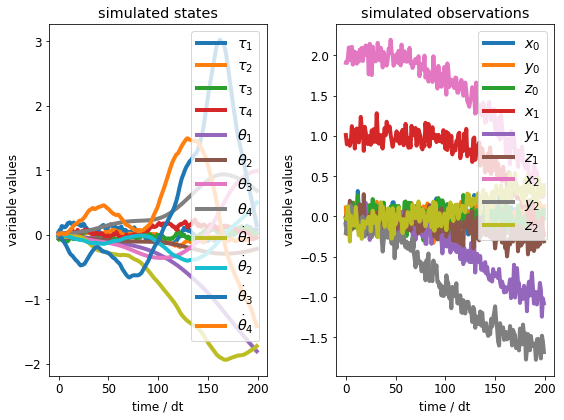

In [33]:
ind_in_batch = 1
arm_utils.plot_simulated_data(lat_data_np, 
                        sim_data_np, 
                        ind_in_batch,
                        label_dict_full,
                       plot_folder + '/sim_dataset.png')

In [32]:
# from scipy.special import logsumexp # sometimes needed

In [35]:
inference_result = inference.infer_latents(full_model, 
                                 sim_observs, 
                                 num_particles)

run time for 200 timesteps, 64 batches, 1000 particles = 315.94


In [36]:
inference_result = utils_summary.send_inference_result_to_cpu(inference_result)

In [50]:
# keys = inference_result.keys()
# for key in keys:
#     #print(key)
#     if type(inference_result[key]) is torch.Tensor:
#         inference_result[key] = inference_result[key].cpu()
#     elif type(inference_result[key]) is list:
#         if len(inference_result[key]) > 0:
#             for i in range(len(inference_result[key])):
#                 inference_result[key][i] = inference_result[key][i].cpu()

In [37]:
# summarize posterior separately for each batch element.
# if batches are identical, each includes an independent SMC sample
posterior_summary = utils_summary.summarize_posterior(inference_result)

applying uniform average of 64 SMC samplers.
applying weighted average of 64 SMC samplers.


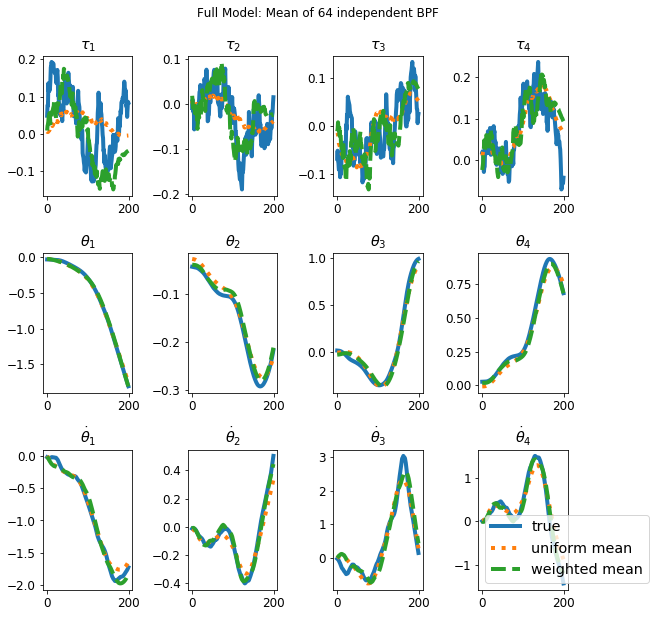

In [38]:
# comparison of uniform and weighted means
# uniform:
mean, var = utils_summary.summarize_independent_smc_samplers(
    posterior_summary["smooth_mean"],
    posterior_summary["smooth_var"],
    logw=None,
    method='uniform')
# weighted:
weighted_mean, weighted_var = utils_summary.summarize_independent_smc_samplers(
    posterior_summary["smooth_mean"],
    posterior_summary["smooth_var"],
    logw=inference_result["log_marginal_likelihood"].detach().numpy(),
    method='weighted',
    remove_indices=None)  # typically better to remove 1/2 dominating indices

# plot the two estimates.
f, axarr = plt.subplots(3, 4, figsize=(9, 9))
axarr = axarr.flatten()
for i in range(lat_data_np.shape[1]):
    axarr[i].plot(lat_data_np[0, i, :], label='true')
    axarr[i].plot(mean[i, :], linestyle='dotted', label='uniform mean')
    axarr[i].plot(weighted_mean[i, :],
                  linestyle='dashed',
                  label='weighted mean')
    axarr[i].set_title(label_dict_full["state"][i])
    if i == lat_data_np.shape[1] - 1:
        plt.legend()
f.suptitle('Full Model: Mean of %i independent BPF' % batch_size)
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(plot_folder + '/mean_of_64_filters.png')

independent SMC ESS: 2
(array([3]),)


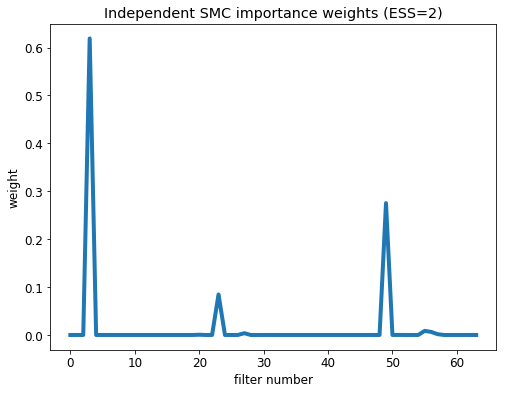

In [45]:
from scipy.special import logsumexp
logw = inference_result["log_marginal_likelihood"].detach().numpy()
w = np.exp(logw - logsumexp(logw))
plt.plot(w)
independent_SMC_ESS = 1.0 / np.sum(w**2)
print('independent SMC ESS: %d' % independent_SMC_ESS)
print(np.where(w==np.max(w)))
plt.ylabel('weight')
plt.xlabel('filter number')
plt.title('Independent SMC importance weights (ESS=%d)' % independent_SMC_ESS)
plt.savefig(os.path.join(plot_folder, 'ind_smc_importance_weights.png'))

In [40]:
#np.sort(w) # note that many some w's are == 0. check that in future.

In [41]:
# if you want indices of best and worst filters, run these lines.
#np.where(np.isin(w, np.sort(w)[-2:])) # which are the two best filters
#np.where(~np.isin(w, np.sort(w)[-2:])) # worst filters

/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


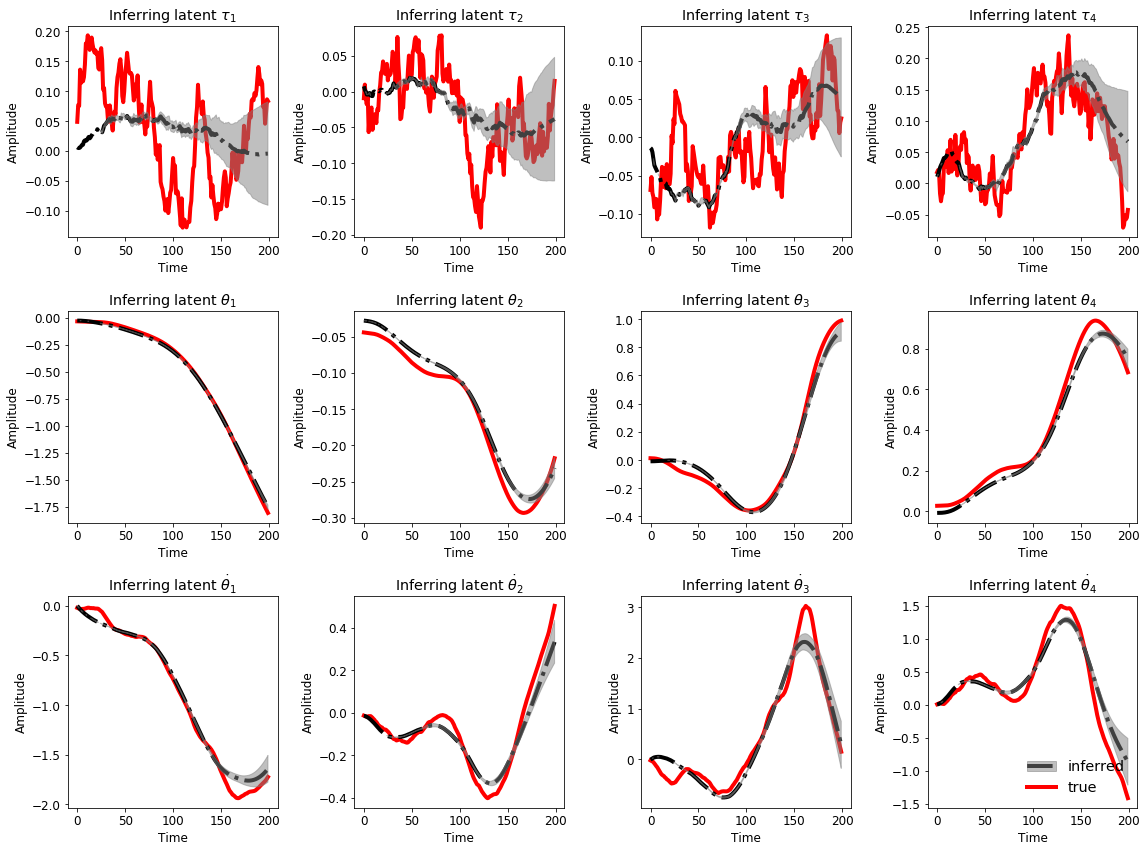

In [42]:
# another version of the plot, incorporating variances.
fig_full_path = plot_folder + '/uniform.png'
nrows = 3
num_latents = lat_data_np.shape[1]
fig, axs = plt.subplots(nrows,
                        int(num_latents / nrows),
                        figsize=(16, 12),
                        sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(mean.shape[0]):
    if i == num_latents-1:
        plt_leg = True
    arm_utils.plot_posterior_trace(
    post_mean=mean[i,:],
    post_var=np.sqrt(var[i,:]),
    data_vec=lat_data_np[ind_in_batch, i, :],
    alpha=0.5,
    plot_legend=plt_leg,
    plot_uncertainty=True,
    plot_true_data=True,
    legends_list=["inferred", "true"],
    legend_loc="lower right",
    title="Inferring latent " + label_dict_full["state"][i],
    xlabel='Time',
    ylabel='Amplitude',
    fig_fullname=None,
    ax=axs[i])
fig.tight_layout()
plt.savefig(fig_full_path)

/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


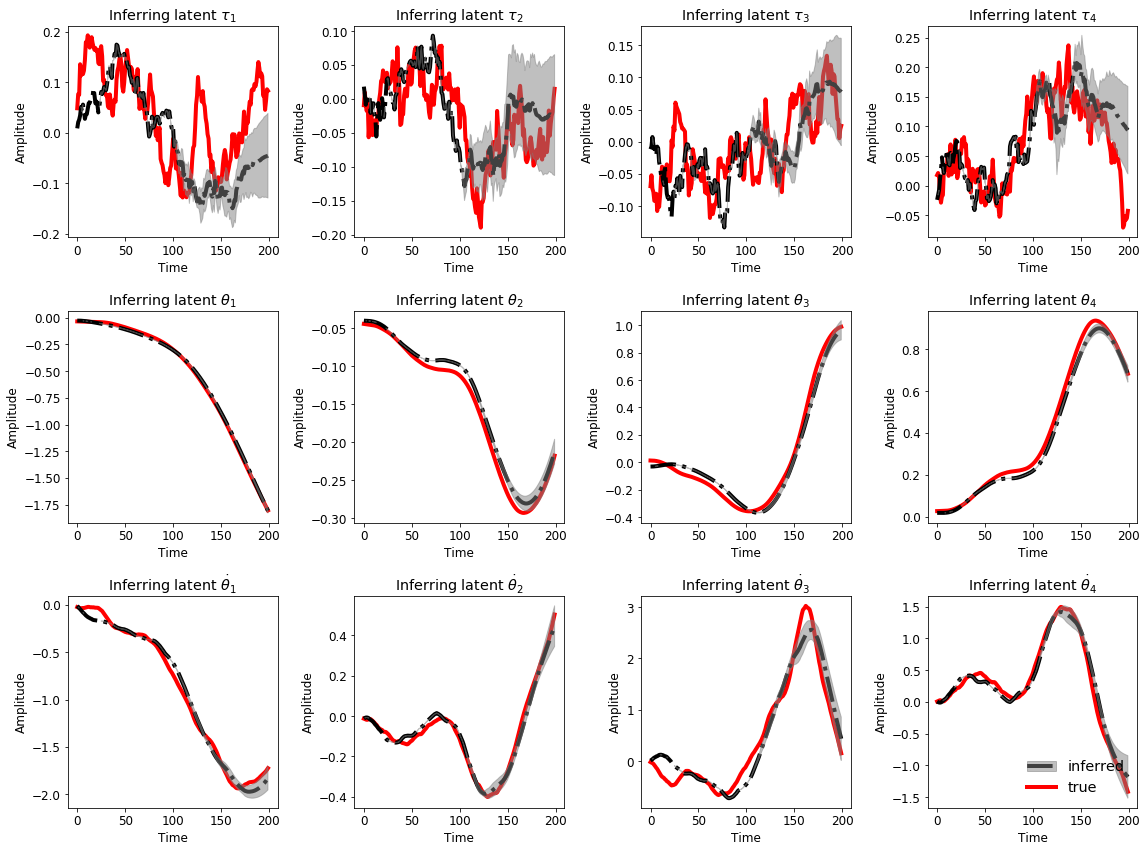

In [43]:
# another version of the plot, incorporating variances.
fig_full_path = plot_folder + '/weighted.png'
nrows = 3
num_latents = lat_data_np.shape[1]
fig, axs = plt.subplots(nrows,
                        int(num_latents / nrows),
                        figsize=(16, 12),
                        sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(weighted_mean.shape[0]):
    if i == num_latents-1:
        plt_leg = True
    arm_utils.plot_posterior_trace(
    post_mean=weighted_mean[i,:],
    post_var=np.sqrt(weighted_var[i,:]),
    data_vec=lat_data_np[ind_in_batch, i, :],
    alpha=0.5,
    plot_legend=plt_leg,
    plot_uncertainty=True,
    plot_true_data=True,
    legends_list=["inferred", "true"],
    legend_loc="lower right",
    title="Inferring latent " + label_dict_full["state"][i],
    xlabel='Time',
    ylabel='Amplitude',
    fig_fullname=None,
    ax=axs[i])
fig.tight_layout()
plt.savefig(fig_full_path)

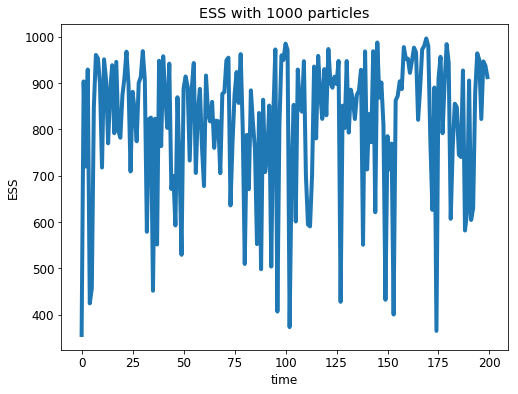

In [44]:
# plot ESS
ind_in_batch = 22
plt.plot(posterior_summary["ESS"][ind_in_batch,:])
plt.xlabel('time')
plt.ylabel('ESS')
plt.title('ESS with %i particles' % num_particles);
plt.savefig(plot_folder+'/ESS_1.png')

Evaluate log joint of true data and inferred means:
$$
\log{}p(x,y) = \sum_{t}^{T} [ \log{}p(x_{t}|x_{t-1}) + \log{}p(y_{t}|x_{t})]
$$
which can be evaluated either for the simulated $x_t$ or for $\hat{x}_t : = \mathbb{E}_{p(x_t | y_{1:T})}[x_t]$

In [63]:
#posterior_summary["smooth_mean"].shape
inferred_mean_list = []
for i in range(posterior_summary["smooth_mean"].shape[-1]):
    inferred_mean_list.append(torch.tensor(posterior_summary["smooth_mean"][:,:,i]))

In [61]:
# ToDo: should re implement inferred_mean_list (deleted somehow!). loop over the inferred means and make them into a list.
log_joint_true = statistics.compute_log_joint(full_model, sim_lats, sim_observs)
log_joint_inferred = statistics.compute_log_joint(full_model, inferred_mean_list, sim_observs)

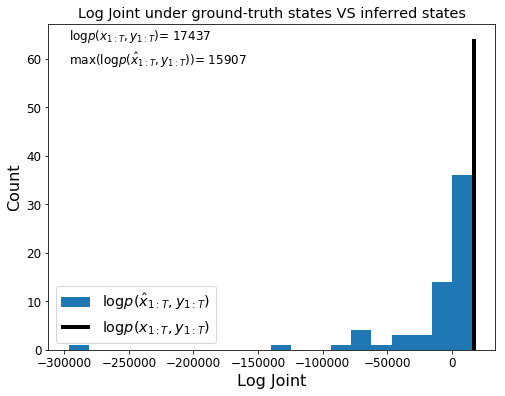

In [64]:
plt.hist(log_joint_inferred.numpy(), bins = 20, label = r'$\log{}p(\hat{x}_{1:T},y_{1:T})$')
plt.vlines(ymin = 0, ymax = batch_size, x=log_joint_true.numpy()[-1], label = r'$\log{}p(x_{1:T},y_{1:T})$')
plt.xlabel('Log Joint', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.legend(loc = 'lower left')
plt.title('Log Joint under ground-truth states VS inferred states');
text_str_true = r'$\log{}p(x_{1:T},y_{1:T})$' + '= %d' % log_joint_true.numpy()[-1]
text_str_inferred = r'$\max{}(\log{}p(\hat{x}_{1:T},y_{1:T}))$' + '= %d' % np.max(log_joint_inferred.numpy()) 
plt.text(y=batch_size, x = np.min(log_joint_inferred.numpy()),  s=text_str_true)
plt.text(y=batch_size-5, x = np.min(log_joint_inferred.numpy()),  s=text_str_inferred)
plt.savefig(plot_folder + '/log_joints.png')

Smooth the results using the FFBS algorithm, the more `K_realizations`, the better.

In [65]:
# create a smoothing instance
from aesmc.smoothing import smooth_result
k_realizations = 20
smoothing_instance = smooth_result(full_model, 
                                   inference_result,
                                   k_realizations)
# run backward smoothing
smoothing_instance.run_backward_smoothing()

# summarize result (over k realizations)
smooth_mean, smooth_var = smoothing_instance.summarize()

print("shape of smooth_mean and smooth_var:")
print(smooth_mean.shape)

shape of smooth_mean and smooth_var:
(64, 12, 200)


In [69]:
# in the case of multiple independent samplers in the batch dimension
# otherwise, each batch contains its own data and no more summary is required.
weighted_smooth_mean, weighted_smooth_var = utils_summary.summarize_independent_smc_samplers(
    smooth_mean,
    smooth_var,
    logw=inference_result["log_marginal_likelihood"].detach().numpy(),
    method='weighted',
    remove_indices=None) 

applying weighted average of 64 SMC samplers.


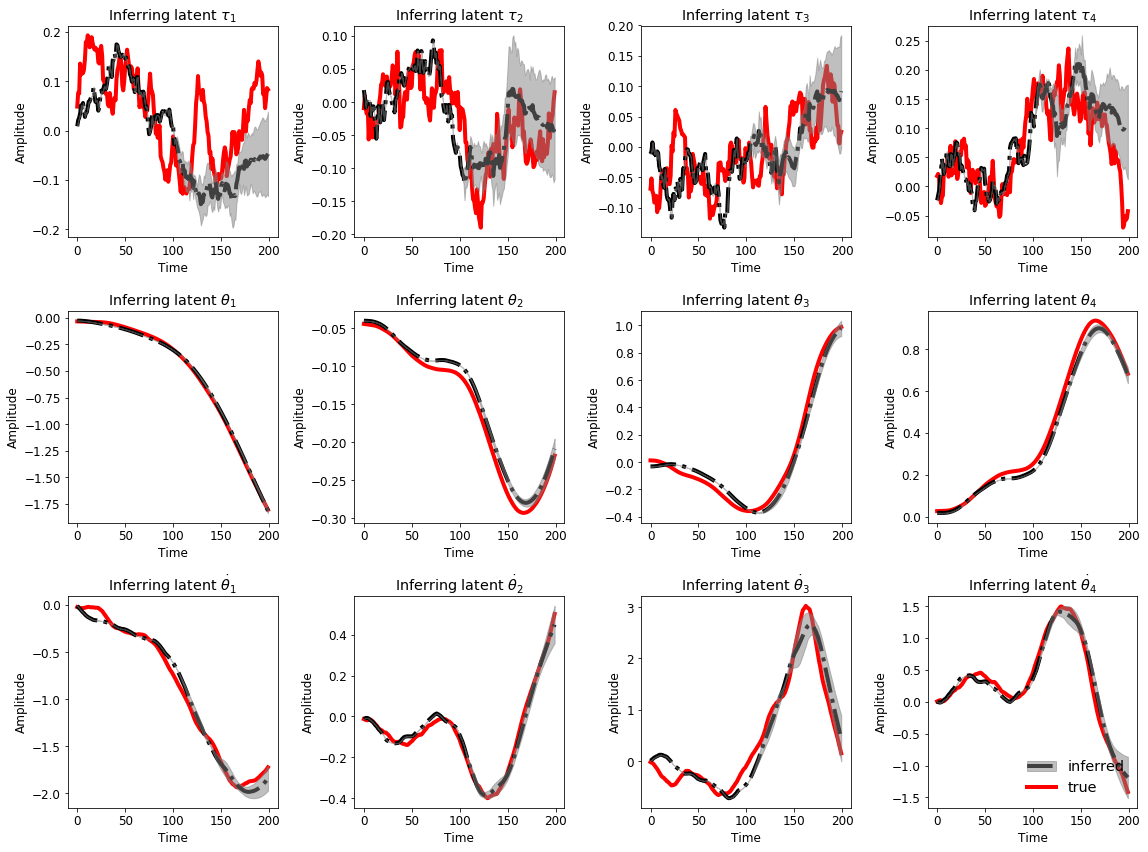

In [70]:
# another version of the plot, incorporating variances.
fig_full_path = plot_folder + '/FFBS_BPF_infer_latents.png'
nrows = 3
num_latents = lat_data_np.shape[1]
fig, axs = plt.subplots(nrows,
                        int(num_latents / nrows),
                        figsize=(16, 12),
                        sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(weighted_mean.shape[0]):
    if i == num_latents-1:
        plt_leg = True
    arm_utils.plot_posterior_trace(
    post_mean=weighted_smooth_mean[i,:],
    post_var=np.sqrt(weighted_smooth_var[i,:]),
    data_vec=lat_data_np[ind_in_batch, i, :],
    alpha=0.5,
    plot_legend=plt_leg,
    plot_uncertainty=True,
    plot_true_data=True,
    legends_list=["inferred", "true"],
    legend_loc="lower right",
    title="Inferring latent " + label_dict_full["state"][i],
    xlabel='Time',
    ylabel='Amplitude',
    fig_fullname=None,
    ax=axs[i])
fig.tight_layout()
plt.savefig(fig_full_path)

In [37]:
## if simulate all the way forward to coords.
#x_obs = sim_data_np[ind_in_batch, [0,2,4], :].T
#y_obs = sim_data_np[ind_in_batch, [1,3,5], :].T
## if simulate only to angles and velocities.
x_obs, y_obs = arm_utils.coords_from_params_mat(
   lat_data_np[ind_in_batch,2,:], 
    lat_data_np[ind_in_batch,3,:], 
                inits_dict["L1"], inits_dict["L2"]) 
print(y_obs.shape)

(200, 3)


In [38]:
# TODO: make sure to input right params for learning
# this is the version for weighted average of BPFs
x_hat , y_hat = arm_utils.coords_from_params_mat(
   weighted_mean[2,:], 
    weighted_mean[3,:], 
                inits_dict["L1"], inits_dict["L2"]) 
x_hat.shape

(200, 3)

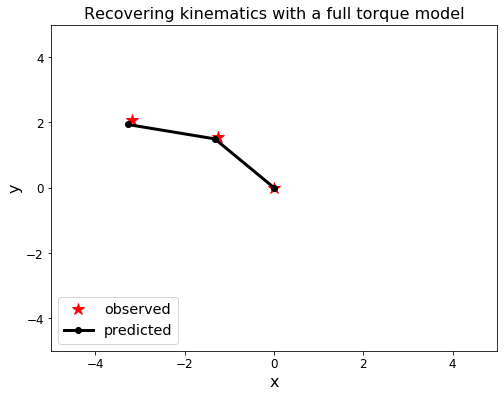

In [39]:
arm_utils.video_sim_plane_2D(x_obs, y_obs, 
                             x_hat, y_hat, 
                             plot_folder+'/recover_dyn', 
                   "Recovering kinematics with a full torque model", 
                             x_hat.shape[0], inits_dict["L1"] + 
                             inits_dict["L2"] + 1)

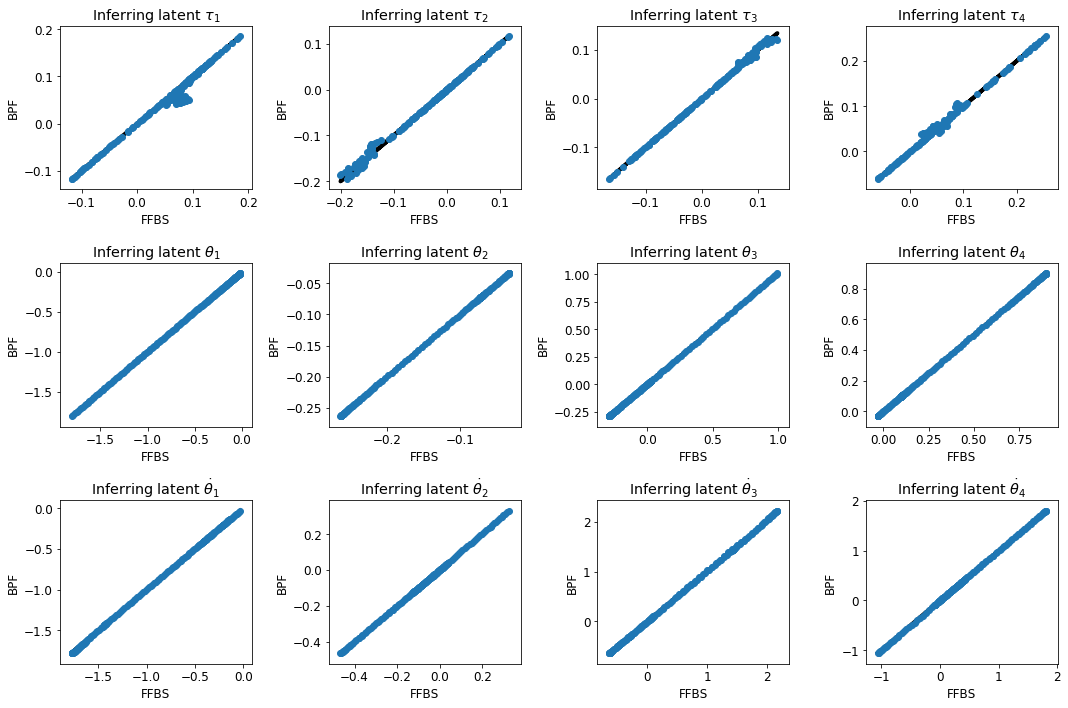

In [72]:
titles = ['$x_{1}$', '$x_{2}$']
plt_leg = False
nrows = 3
fig, axs = plt.subplots(nrows,int(posterior_summary["smooth_mean"].shape[1]/nrows), 
                        figsize = (15,10), sharey=False)
axs = axs.flatten()
for i in range(posterior_summary["smooth_mean"].shape[1]):
    
    if i == 0:
        label = '$x_{1} = f$'
    elif i == 1:
        label = '$x_{2} = x$'
    elif i == 2:
        label = '$x_{3} = \dot{x}$'
        plt_leg = True
    
    axs[i].plot(smooth_mean[ind_in_batch,i,:], 
                smooth_mean[ind_in_batch,i,:], 'k') # diag line
    axs[i].scatter(smooth_mean[ind_in_batch,i,:], 
            posterior_summary["smooth_mean"][ind_in_batch,i,:], 
                   zorder=3)
    axs[i].set_xlabel('FFBS')
    axs[i].set_ylabel('BPF')
#     axs[i].plot(filtered_state_means[:,i], color = 'black', linestyle = 'dotted', 
#                 label = 'Kalman filter');
    axs[i].set_title("Inferring latent " +  label_dict_full["state"][i])

fig.tight_layout()
plt.savefig(plot_folder+'/compare_FFBS_BPF.png')

Implement learning of $M_1$ and $M_2$

In [29]:
sim_data_np.shape

(16, 6, 200)

In [35]:
sim_data_np[0, :2, :]

array([[ 5.70418582e-02, -1.26147187e-01,  7.33463124e-02,
        -1.06593631e-03,  2.47888052e-02, -2.22029565e-01,
        -8.18543951e-02, -2.51541028e-01, -8.01100919e-02,
        -2.31288582e-02, -7.02392525e-02, -1.77268907e-01,
         2.89053106e-01,  1.63828490e-02, -1.90669266e-01,
         7.54882909e-02,  1.19438432e-01,  2.13900395e-02,
         3.19796050e-02,  1.90996601e-01,  1.32161615e-01,
         1.18693354e-01,  4.96322846e-02, -5.77234386e-02,
         5.99473435e-02, -7.47436410e-02, -3.49145487e-01,
         3.36627451e-01,  2.93188017e-02,  1.38095598e-01,
         7.88760159e-02, -1.46822371e-02, -1.35461429e-01,
         3.88674974e-01,  1.61835988e-01, -8.74782858e-02,
         1.82245095e-01, -1.15807996e-01, -1.59490798e-01,
        -1.74081084e-01,  2.35196582e-01,  1.15926201e-04,
        -3.71860548e-02,  2.13730724e-01, -3.26950107e-01,
        -1.16073656e-01, -1.65290985e-01, -5.48096284e-02,
        -1.08871898e-01, -2.64580158e-01, -7.58570321e-0

In [44]:
empirical_estimate_L1 = np.linalg.norm(sim_data_np[0, 2:4, :] - sim_data_np[0, :2, :], axis=0)
empirical_estimate_L2 = np.linalg.norm(sim_data_np[0, 4:, :] - sim_data_np[0, 2:4, :], axis=0)

In [48]:
(inits_dict["L1"] - np.median(empirical_estimate_L1)) / inits_dict["L1"]

-0.003617780302634266

In [49]:
(inits_dict["L2"] - np.median(empirical_estimate_L2)) / inits_dict["L2"]

-0.009406472491689799

In [52]:
# look at fw kin learning script for variables, etc.

2.0

In [22]:
learning_arm_params = False
if learning_arm_params:
    learning_inits_dict = {}
    learning_inits_dict['L1'] = inits_dict["L1"] + 0.5 # for now, can be empirical estimate or learned
    learning_inits_dict['L2'] = inits_dict["L1"] - 0.5 # same
    learning_inits_dict['M1'] = inits_dict["M1"] - 0.6 # test init for true == 1.1
    learning_inits_dict['M2'] = inits_dict["M2"] + 0.7 # test init for true == 1.1
else:
    learning_inits_dict = inits_dict
print(learning_inits_dict)

{'L1': 1.0, 'L2': 1.0, 'M1': 0.25, 'M2': 0.3}


In [23]:
arm_model_learning = arm_3d_dyn_model.Arm_3D_Dyn(
    dt=dt,
    inits_dict=inits_dict,
    g=g,
    include_gravity_fictitious=True,
    transform_torques=False,
    learn_static=learning_arm_params,
    restrict_to_plane=True) # Remove True in full model!

In [24]:
list(arm_model_learning.parameters())

[Parameter containing:
 tensor(1.),
 Parameter containing:
 tensor(1.),
 Parameter containing:
 tensor(0.2500),
 Parameter containing:
 tensor(0.3000)]

In [25]:
param_dict
# ToDo: there are more params you can add to param dict?

{'init_mu': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'init_cov': array([[0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5]])}

In [26]:
learning_model = {}
'''full_model includes arm dynamics, and FW-KIN emission.
here we learn M1 and M2'''

learning_model["initial"] = arm_3d_dyn_model.Initial(param_dict["init_mu"],
                                                     param_dict["init_cov"])

learning_model["transition"] = arm_3d_dyn_model.Transition(
    dt, transition_force_scale, transition_aux_scale, arm_model_learning)

learning_model["emission"] = arm_3d_dyn_model.Emission(inits_dict, #ToDo: inits_dict is now redundant for L1,L2
                                                       np.eye(9) *
                                                       emission_var_diag,
                                                       arm_model_learning,
                                                       theta_indices=[4,5,6,7])

learning_model["proposal"] = arm_3d_dyn_model.Learned_Proposal( \
                               learning_model["initial"], 
                                learning_model["transition"],
                                20)

In [27]:
num_timesteps

100

In [28]:
# running params
num_timesteps = 100
saving_interval = 10
logging_interval = 1
batch_size = 64 # 64 is good for independent SMC. the higher the better.
num_iterations = 10
num_particles = 500
num_epochs = 100

In [44]:
dataloader = train.get_synthetic_dataloader(
            full_model["initial"],
            full_model["transition"],
            full_model["emission"],
            num_timesteps, batch_size)

In [36]:
# ToDo: look at the aesmc original script for training
training_stats = arm_3d_dyn_model.TrainingStats(true_inits_dict=inits_dict,
                arm_model_instance = arm_model_learning,
                num_timesteps = num_timesteps,
                logging_interval = logging_interval)

In [29]:
arm_model_learning.to("cuda" if torch.cuda.is_available() else "cpu")

Arm_3D_Dyn()

In [30]:
# # just for now, but should be set . no need to run. can change defs here
# for param in list(arm_model_learning.parameters()):
#     parm.requires_grad = True
# print(list(arm_model_learning.parameters()))

In [31]:
from scipy.special import logsumexp

In [32]:
import itertools

def get_chained_params(*objects):
    result = []
    for object in objects:
        if (object is not None) and isinstance(object, nn.Module):
            result = itertools.chain(result, object.parameters())

    if isinstance(result, list):
        return None
    else:
        return result
    
def train_single_dataset(observations, num_particles, algorithm, initial, transition, emission,
          proposal, num_epochs, num_iterations_per_epoch=None,
          optimizer_algorithm=torch.optim.Adam, optimizer_kwargs={},
          callback=None):
    
    parameters = get_chained_params(initial, transition, emission, proposal)
    optimizer = optimizer_algorithm(parameters, **optimizer_kwargs)
    for epoch_idx in range(num_epochs):
        if torch.sum(torch.isnan(torch.cat(observations)))>0:
                continue
        optimizer.zero_grad()
        loss = losses.get_loss(observations, num_particles, algorithm,
                               initial, transition, emission, proposal)
        loss.backward()
        optimizer.step()
        
        print(loss.cpu().numpy())

In [37]:
train_single_dataset(observations = sim_observs,
            num_particles=num_particles,
            algorithm='aesmc',
            initial=learning_model["initial"],
            transition=learning_model["transition"],
            emission=learning_model["emission"],
            proposal=learning_model["proposal"],
            num_epochs=num_epochs,
            num_iterations_per_epoch=num_iterations,
            callback=None)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.78 GiB total capacity; 14.35 GiB already allocated; 10.44 MiB free; 14.69 GiB reserved in total by PyTorch)

In [49]:
train.train(dataloader=dataloader,
            num_particles=num_particles,
            algorithm='aesmc',
            initial=learning_model["initial"],
            transition=learning_model["transition"],
            emission=learning_model["emission"],
            proposal=learning_model["proposal"],
            num_epochs=num_epochs,
            num_iterations_per_epoch=num_iterations,
            callback=training_stats)

each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.


KeyboardInterrupt: 

In [50]:
# debug nans in the dataloader
num_iterations_per_epoch = num_iterations
for epoch_idx in range(num_epochs):
    torch.manual_seed(0) # to make sure data loader repeats batches across epochs.
    for epoch_iteration_idx, observations in enumerate(dataloader):
        nan_counts = np.sum(np.isnan(torch.cat(observations).cpu().numpy()))
        if nan_counts>0:
            print(nan_counts)
        if num_iterations_per_epoch is not None:
            if epoch_iteration_idx == num_iterations_per_epoch:
                break

each batch contains different data.
240
each batch contains different data.
198
each batch contains different data.
252
each batch contains different data.
252
each batch contains different data.
306
each batch contains different data.
162
each batch contains different data.
210
each batch contains different data.
198
each batch contains different data.
102
each batch contains different data.
264
each batch contains different data.
198
each batch contains different data.
240
each batch contains different data.
198
each batch contains different data.
252
each batch contains different data.
252
each batch contains different data.
306
each batch contains different data.
162
each batch contains different data.
210
each batch contains different data.
198
each batch contains different data.


KeyboardInterrupt: 

In [33]:
training_stats.curr_params_list

[array([2.49700022, 1.49699986, 0.49700004, 1.89699984]),
 array([2.49400926, 1.49793363, 0.4989669 , 1.89731312]),
 array([2.49107742, 1.49938333, 0.50068009, 1.89818633]),
 array([2.488065  , 1.50084352, 0.50290495, 1.89820015]),
 array([2.4851253 , 1.50281751, 0.50551438, 1.90007496]),
 array([2.48240852, 1.50460708, 0.50689256, 1.90183008]),
 array([2.47966623, 1.50586808, 0.50735027, 1.90305948]),
 array([2.47681284, 1.50688112, 0.50774562, 1.90401912]),
 array([2.47378564, 1.50753689, 0.50755501, 1.90464509]),
 array([2.47074509, 1.50797939, 0.50734842, 1.90505576]),
 array([2.46790624, 1.50833714, 0.50741404, 1.90537548]),
 array([2.4668138 , 1.50765264, 0.50564218, 1.90488935]),
 array([2.4658637 , 1.50678515, 0.50434196, 1.90419471]),
 array([2.46639371, 1.50420797, 0.50180221, 1.90163028]),
 array([2.46706963, 1.50164759, 0.49926013, 1.8990767 ]),
 array([2.4672091 , 1.49973607, 0.49735665, 1.89717078]),
 array([2.4668169 , 1.49832559, 0.49593547, 1.89576614]),
 array([2.4659

In [36]:
learning_model["proposal"]

Learned_Proposal(
  (transition): Transition(
    (arm_model): Arm_3D_Dyn()
  )
  (FF_mu): Sequential(
    (0): Linear(in_features=9, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=12, bias=True)
  )
  (FF_var): Sequential(
    (0): Linear(in_features=9, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=12, bias=True)
    (3): Softplus(beta=1, threshold=20)
  )
)

In [34]:
params = np.asarray(training_stats.curr_params_list)
print(params)

[[2.49700022 1.49699986 0.49700004 1.89699984]
 [2.49400926 1.49793363 0.4989669  1.89731312]
 [2.49107742 1.49938333 0.50068009 1.89818633]
 ...
 [2.16396403 1.48020077 0.50613308 1.86156929]
 [2.16436934 1.4805733  0.50662583 1.86199868]
 [2.16406298 1.48040545 0.5069297  1.8618288 ]]


$M_1 : = 1, M_2 = \lambda \cdot M_1$ 
since we can init $L$ properly from observations, maybe fix $L$'s and $M_1$ -- can we infer $M_2$?
If this becomes hard, just fix all params and ignore the learning problem.

In [49]:
L1_in_training  = np.zeros(len(training_stats.curr_params_list))
L2_in_training  = np.zeros(len(training_stats.curr_params_list))

for i in range(len(training_stats.curr_params_list)):
    L1_in_training[i] = training_stats.curr_params_list[i][0]
    L2_in_training[i] = training_stats.curr_params_list[i][1]

NameError: name 'L1_in_training' is not defined

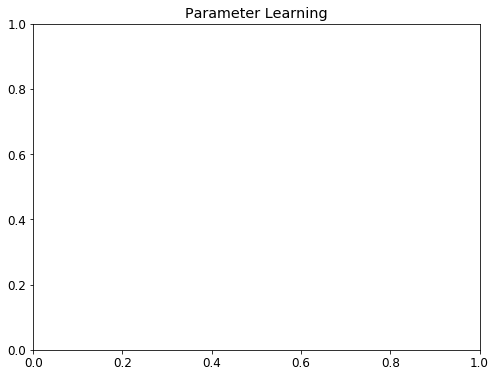

In [57]:
plt.title('Parameter Learning')
plt.plot(L1_in_training, label = r"$L_1$")
plt.plot(L2_in_training, label = r"$L_2$")
plt.plot([0, len(L1_in_training)], [2.0, 2.0], 'k', label = "True length")
plt.xlabel('training_iteration/10')
plt.legend()

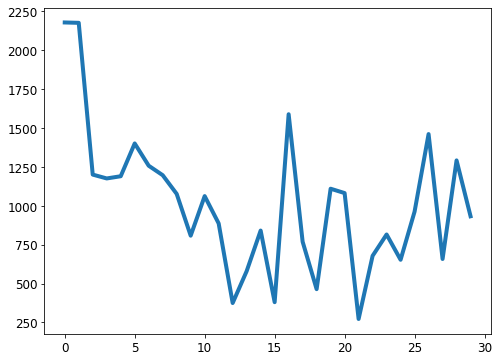

In [56]:
plt.plot(training_stats.loss)